# SISTER CWL submission

In [ ]:
import json
import os
import xml.etree.ElementTree as ET
import pandas as pd
import requests
import IPython

# Import warnings module and ignore warnings in output below
import warnings
warnings.filterwarnings("ignore")

# Import and initialize MAAP class
from maap.maap import MAAP
maap = MAAP(maap_host="sister-api.imgspec.org")

In [ ]:
def get_output(job_id):
    result = maap.getJobResult(job_id)
    granule = result.outputs[0] 
    quicklook = result.outputs[0].replace('.tar.gz','.png')
    
    log_url = result.outputs[0].replace('.tar.gz','.log')
    log_response = requests.get(log_url)
    log = log_response.text
    
    return granule,quicklook,log

## Load production list with scene URLs


In [38]:
scene_df = pd.read_csv('./sister_production_1_list.csv', encoding='utf-8-sig')
# Strip unicode character
scene_df.l1_granule = scene_df.l1_granule.map(lambda x: x.replace('\ufeff',''))
scene_df.tail()

,Instrument,Type,Area,Flight Line,Platform,l1_granule,Valid URL,Notes,Output(s),Output name(s)
95,DESIS,Validation,MOBY,DT0623620108_006-20210820T011554-V0215,4,https://sister-ops-workspace.s3.us-west-2.amaz...,True,NaN,Corrected reflectance,SISTER_DESIS_20210820T011554_CORFL_CRID.tar.gz
96,DESIS,Validation,La Crau RadCalNet,DT0729839672_002-20220606T114600-V0215,4,https://sister-ops-workspace.s3.us-west-2.amaz...,True,NaN,Corrected reflectance,SISTER_DESIS_20220606T114600_CORFL_CRID.tar.gz
97,DESIS,Aquatic,Heron Reef,DT1120210359_005-20211120T035820-V0215,4,https://sister-ops-workspace.s3.us-west-2.amaz...,True,NaN,Corrected reflectance,SISTER_DESIS_20211120T035820_CORFL_CRID.tar.gz
98,DESIS,Aquatic,"Kaneohe Bay, Oahu",DT0685618328_002-20220204T204959-V0215,4,https://sister-ops-workspace.s3.us-west-2.amaz...,True,NaN,Corrected reflectance,SISTER_DESIS_20220204T204959_CORFL_CRID.tar.gz
99,DESIS,Aquatic,Heron Reef,DT0695506224_002-20220303T015703-V0215,4,https://sister-ops-workspace.s3.us-west-2.amaz...,True,NaN,Corrected reflectance,SISTER_DESIS_20220303T015703_CORFL_CRID.tar.gz


## Workflow configuration generator

The configuration generator function takes as input the URL to the L1 granule and returns a scene identifier along with a workflow configuration for the scene

In [ ]:
def gen_config(l1_granule):
    
    '''Generate CWL workflow configuration
    
    Arguments
    
    l1_granule (str): Input scene URL 
    
    Returns:
    
    identifier(str): Unique scene identification code
    
            SISTER_SENSOR_YYYMMDDTHHMMSS
        ex:
    
            SISTER_PRISMA_20200918T100312
            
    input_config (list): List of workflow PGE configurations

    '''
    
    landsat = 'None'   
    
    base_name = os.path.basename(l1_granule)
    
    if base_name.startswith('DESIS'):
        sensor = 'DESIS'
        datetime = base_name[31:46]
        
    elif base_name.startswith('PRS'):
        sensor = 'PRISMA'
        datetime = base_name[16:24] + 'T' + base_name[24:30]
        landsat='https://sister-ops-workspace.s3.us-west-2.amazonaws.com/prisma/landsat_reference/PRS_%s_landsat.tar.gz' % base_name[16:50]
        
    elif base_name.startswith('ang'):
        sensor = 'AVNG'
        datetime = base_name[3:18].upper()
        
    elif base_name.startswith('f'):
        sensor = 'AVCL'
        ''' AVIRIS classic filenames do not contain acquisition times,to be consistent with other
            sensors and to ensure identifier codes are unique a time string is created using other
            numbers in the filename            
        '''     
        
        datetime = "20%sT%s%s%s" % (base_name[1:7],
                                    base_name[8:10],
                                    base_name[11:13],
                                    base_name[14:16])
        
    #Check if input file exists
    inputs_exist = requests.head(l1_granule).status_code != 500
    # Check if landsat reference file exists
    if sensor == 'PRISMA':
        inputs_exist &= requests.head(landsat).status_code != 500
        
    if not inputs_exist:
        print('Input file not found.')
        return False,False
    
    identifier = 'SISTER_%s_%s' % (sensor,datetime)
    
    input_config =  [
    {
      "step_key": "l1_preprocess",
      "algorithm_id": "sister-preprocess_ubuntu",
      "version": "1.0.0",
      "queue": "sister-job_worker-32gb",
      "params": {
        "l1_granule": l1_granule,
        "landsat": landsat,
        "publish_to_cmr": False,
        "cmr_metadata": {},
        "identifier": "%s_L1B_RDN" % identifier,
        "username":"anonymous"
      }
    },
    {
      "step_key": "l2_reflectance",
      "algorithm_id": "sister-isofit_ubuntu",
      "queue": "sister-job_worker-32gb",
      "version": "1.0.0",
      "input_filter": {
        "l1_granule": "*RDN*.tar.gz"
      },
      "params": {
        "cmr_metadata": {},
        "l1_granule": None,
        "n_cores": 32,
        "publish_to_cmr": False,
        "segmentation_size": 50,
        "snow_and_liquids_reflectance_spectra": "https://ecosis.org/api/package/emit-manually-adjusted-snow-and-liquids-reflectance-spectra/export",
        "surface_reflectance_spectra": "https://ecosis.org/api/package/emit-manually-adjusted-surface-reflectance-spectra/export",
        "vegetation_reflectance_spectra": "https://ecosis.org/api/package/emit-manually-adjusted-vegetation-reflectance-spectra/export",
        "water_reflectance_spectra": "https://ecosis.org/api/package/emit-manually-adjusted-water-reflectance-spectra/export",
        "identifier": "%s_L2A_RFL" % identifier,
        "username":"anonymous"
  
      },

    },
    {
      "step_key": "l2_resample",
      "algorithm_id": "sister-resample_ubuntu",
      "version": "1.1.0",
      "queue": "sister-job_worker-32gb",
      "input_filter": {
        "l2a_granule": "*RFL*.tar.gz"
      },
      "params": {
        "l2a_granule": None,
        "publish_to_cmr": False,
        "cmr_metadata": {},
        "identifier": "%s_L2A_RSRFL" % identifier,
        "username":"anonymous"

      }
    },
    {
      "step_key": "l2_reflectance_correction",
      "algorithm_id": "sister-reflect_correct_ubuntu",
      "version": "1.0.0",
      "queue": "sister-job_worker-32gb",
      "input_filter": {
        "l1b_granule": "*RDN*.tar.gz",
        "l2a_granule": "*RSRFL*.tar.gz"
      },
      "params": {
        "l1b_granule": None,
        "l2a_granule": None,
        "publish_to_cmr": False,
        "cmr_metadata": {},
        "identifier": "%s_L2A_CORFL" % identifier,
        "username":"anonymous"

      }
    }
  ]

    return identifier,json.dumps(input_config,indent=4)
    

## Generate single CWL workflow configuration

In [ ]:
identifier,input_config = gen_config('https://sister-ops-workspace.s3.us-west-2.amazonaws.com/prisma/raw/PRS_L1_STD_OFFL_20200911184039_20200911184043_0001.zip')
print(identifier)
print(input_config)

## Submit single CWL workflow job

In [ ]:
job = maap.submitJob(
       algo_id="run_sister_workflow_ubuntu",
       version="dev",
       queue="sister-job_worker-8gb",
       identifier="%s_cwl_workflow" % identifier,
       username="anonymous",
       workflow_config=input_config)

print("Submitted %s CWL worflow job" %  identifier)
print("    Submission status: %s" % job.status )


## Loop through dataframe and start a CWL workflow for each each input scene 

In [39]:
job_ids = {}

for l1_granule in scene_df.l1_granule[10]:
    scene_name = os.path.basename(l1_granule)       
    print("Submitting %s CWL worflow job" %  scene_name)
    identifier,input_config = gen_config(l1_granule)

    if identifier:
        job = maap.submitJob(
            algo_id="run_sister_workflow_ubuntu",
            version="dev",
            queue="sister-job_worker-8gb",
            identifier="%s_cwl_workflow" % identifier,
            username="anonymous",
            workflow_config=input_config)
        print("    %s submission status: %s" % (identifier,job.status) )
        job_ids[identifier] = job.id

Submitting f130612t01p00r10.tar.gz CWL worflow job
    SISTER_AVCL_20130612T010010 submission status: success
Submitting f130612t01p00r11.tar.gz CWL worflow job
    SISTER_AVCL_20130612T010011 submission status: success
Submitting f130612t01p00r12.tar.gz CWL worflow job
    SISTER_AVCL_20130612T010012 submission status: success
Submitting f130612t01p00r13.tar.gz CWL worflow job
    SISTER_AVCL_20130612T010013 submission status: success
Submitting f130612t01p00r14.tar.gz CWL worflow job
    SISTER_AVCL_20130612T010014 submission status: success


# Display quicklook result

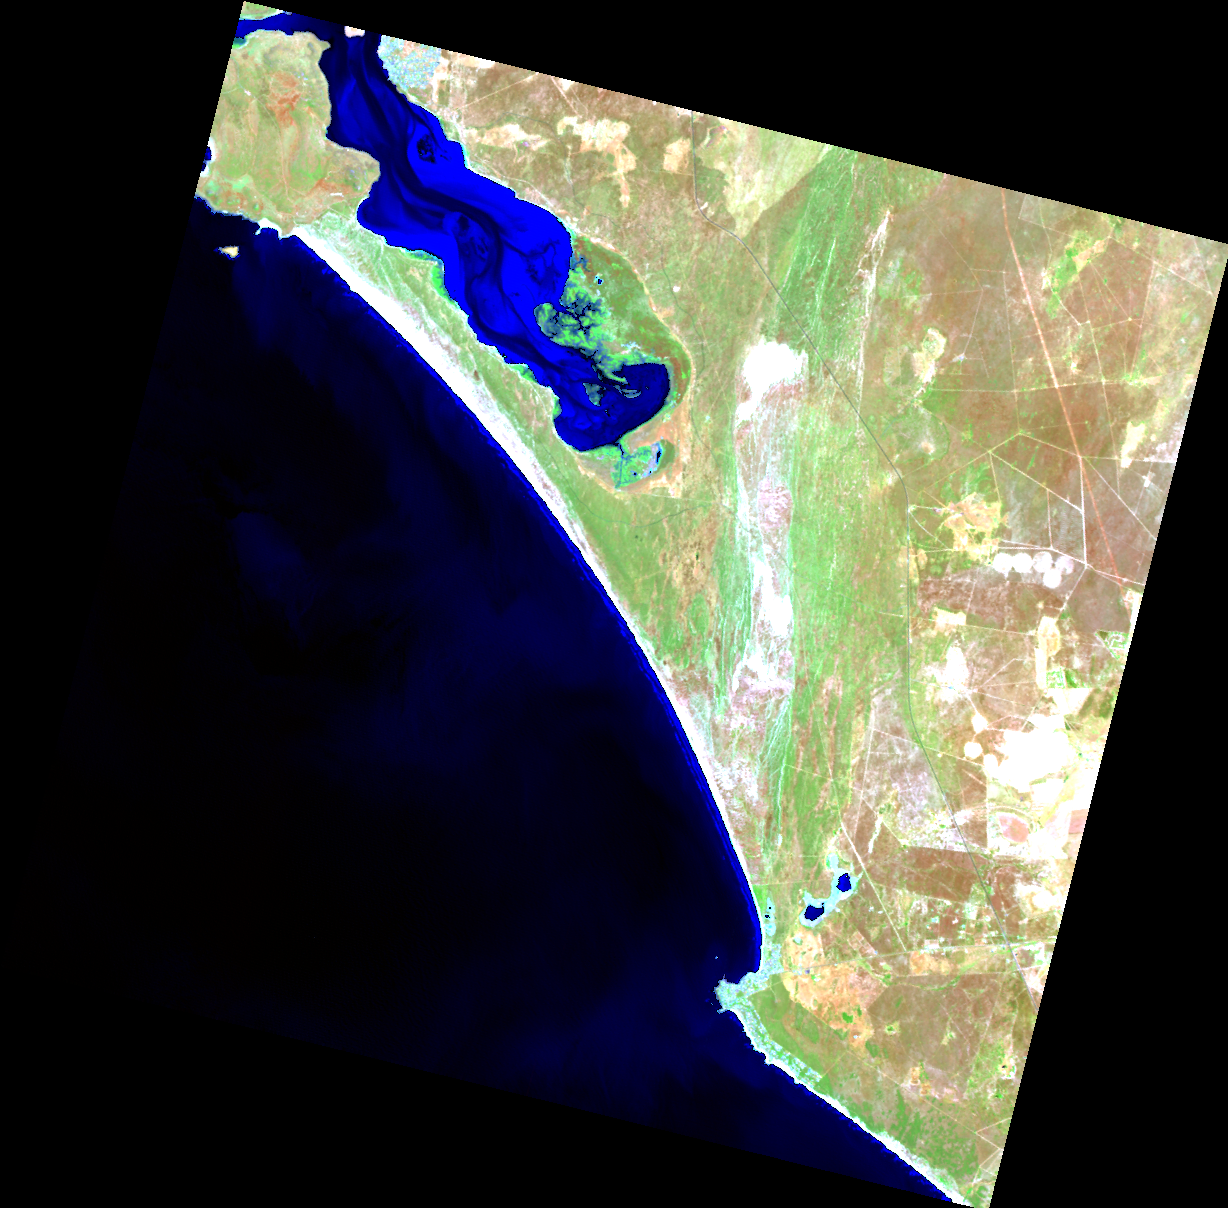

In [40]:
output = get_output('8ac89f66-8f34-42a6-8355-de371f6bcc5a')
IPython.display.Image(output[1],height = 500)